In [1]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import time
import pdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split

# Clustering
from sklearn.datasets import make_biclusters, make_checkerboard, make_classification
from sklearn.datasets import samples_generator as sg
from sklearn.cluster.bicluster import SpectralCoclustering, SpectralBiclustering
from sklearn.metrics import consensus_score

# Corr
from scipy.stats import spearmanr, pearsonr
from numpy import corrcoef

# Utils
file_path = os.getcwd()  # os.path.dirname(os.path.relpath(__file__))
utils_path = os.path.abspath(os.path.join(file_path, '..', '..', 'utils_py'))
sys.path.append(utils_path)
import utils_all as utils

# Feature importance
pfi_path = os.path.abspath(os.path.join(file_path, '..', 'pfi'))
sys.path.append(pfi_path)
import pfi
import pfi_utils

import warnings
warnings.filterwarnings('ignore')

SEED=0

Using TensorFlow backend.


In [2]:
print(file_path)
# DATAPATH_CLASSIFICATION = os.path.join(file_path, 'data', 'data_classification')
DATAPATH_CLASSIFICATION_TRAIN = os.path.join(file_path, 'data', 'data_classification_train')
DATAPATH_CLASSIFICATION_VAL = os.path.join(file_path, 'data', 'data_classification_val')

/vol/ml/apartin/projects/feature-importance/tests


In [3]:
data_train = pd.read_csv(DATAPATH_CLASSIFICATION_TRAIN, sep='\t')
data_val   = pd.read_csv(DATAPATH_CLASSIFICATION_VAL, sep='\t')

In [4]:
print('data_train.shape', data_train.shape)
print('data_val.shape  ', data_val.shape)
print('data_train:\n', data_train.iloc[:3, :4])
print('data_val:\n', data_val.iloc[:3, :4])

data_train.shape (1600, 11)
data_val.shape   (400, 11)
data_train:
    y       A       B        C
0  2 -0.0278  1.2290 -0.10925
1  2 -0.1952  1.0060  1.14000
2  2 -1.1470  0.7837 -0.17100
data_val:
    y       A        B       C
0  2 -1.1860  1.15100  1.1800
1  2  1.3130  0.87300  0.9995
2  0  0.2737 -0.09406 -0.9517


In [5]:
xtr = data_train.iloc[:, 1:].copy()
ytr = data_train.iloc[:, 0].copy()
xvl = data_val.iloc[:, 1:].copy()
yvl = data_val.iloc[:, 0].copy()
features = xtr.columns

In [6]:
rf_model = RandomForestClassifier(n_estimators=200, max_features='sqrt', random_state=SEED)
rf_model.fit(xtr, ytr);
print(f'Prediction score (mean accuracy): {rf_model.score(xvl, yvl):.4f}')

Prediction score (mean accuracy): 0.8550


In [7]:
yvl_pred = rf_model.predict(xvl)
print('true', yvl[:10].values)
print('pred', yvl_pred[:10])
print('f1_score micro: {:.3f}'.format(f1_score(y_true=yvl, y_pred=yvl_pred, average='micro')))
print('f1_score macro: {:.3f}'.format(f1_score(y_true=yvl, y_pred=yvl_pred, average='macro')))

true [2 2 0 1 2 1 1 0 2 1]
pred [2 2 0 0 2 1 1 0 2 1]
f1_score micro: 0.855
f1_score macro: 0.856


In [8]:
yvl_pred_p = rf_model.predict_proba(xvl)
print('true', yvl[:5].values)
print('yvl_pred_p:\n', yvl_pred_p[:5])

true [2 2 0 1 2]
yvl_pred_p:
 [[0.025 0.01  0.965]
 [0.015 0.295 0.69 ]
 [0.67  0.1   0.23 ]
 [0.74  0.185 0.075]
 [0.035 0.01  0.955]]


In [9]:
# cls = 2
# idx = yvl.values == cls
# # y_true_cls = yvl[idx]
# yvl_pred_p_cls = yvl_pred_p[idx,:]
# yvl_pred_p_cls[:, cls].mean()

In [10]:
yvl_pred_p = rf_model.predict_proba(xvl)
dd = {}
for cl in np.unique(yvl.values):
    idx = yvl.values == cl
    # y_true_cl = yvl[idx]
    yvl_pred_p_cl = yvl_pred_p[idx,:]
    dd[cl] = yvl_pred_p_cl[:, cl].mean()  

print(dd)

{0: 0.7214179104477612, 1: 0.7711654135338346, 2: 0.6684586466165413}


In [11]:
utils.get_rf_fi(rf_model=rf_model, columns=xtr.columns)

,col_id,cols,imp,std
0,0,A,0.253943,0.045792
1,1,B,0.184775,0.028447
2,3,D,0.141283,0.022411
3,2,C,0.123776,0.027885
4,4,E,0.112916,0.023265
5,9,J,0.038107,0.010319
6,5,F,0.037376,0.011281
7,8,I,0.037072,0.010546
8,6,G,0.035575,0.010019
9,7,H,0.035177,0.010157


In [15]:
fi_obj = pfi.PFI(model=rf_model, xdata=xvl, ydata=yvl, n_shuffles=20)
fi_obj.gen_col_sets(th=1.0, toplot=False)
fi_obj.compute_pfi(ml_type='c', verbose=False)

Corr matrix after removing features shape:  (0, 0)
Time to compute cliques:  0.00 min


In [16]:
fi_obj.fi_var

,cols,n,imp
0,B,1,0.230627
1,A,1,0.203947
2,E,1,0.168469
3,D,1,0.167059
4,C,1,0.124086
5,I,1,0.022515
6,H,1,0.0221905
7,F,1,0.0218279
8,J,1,0.0210342
9,G,1,0.0182447


In [18]:
# fi_obj.fi_p.iloc[:, 2:]
mat = fi_obj.fi_score_p.sort_values('cols').reset_index(drop=True)
mat = mat.set_index('cols')
mat = mat.drop(columns=['n'])
mat
# pd.DataFrame(fi_obj.fi_p.iloc[:, 2:], index=fi_obj.fi_p['cols'])

,imp_c0,imp_c1,imp_c2
cols,,,
A,0.188937,0.243453,0.0554718
B,0.0833862,0.130727,0.193968
C,0.108134,0.0597124,0.0864793
D,0.0913545,0.113526,0.104352
E,0.138336,0.041953,0.0831805
F,-0.00184515,-0.00178759,-0.00075
G,0.00155597,0.00166541,-0.00398684
H,0.00318657,-0.00024812,-0.00310526
I,-0.000287313,0.00133459,-0.00025188


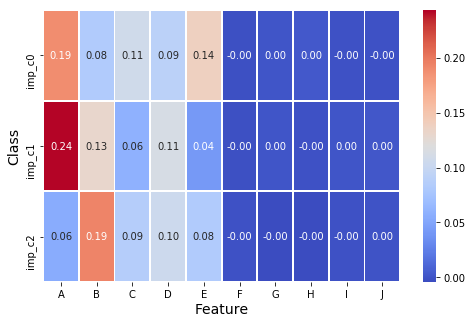

In [20]:
fi_obj.plot_score_fi_p();

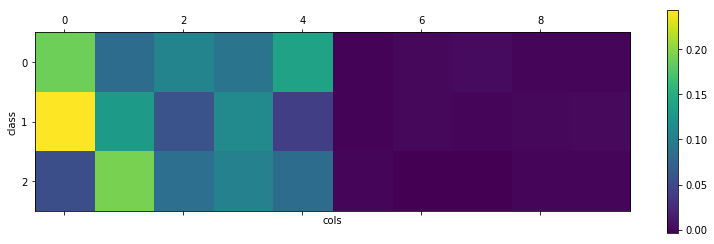

In [21]:
plt.matshow(np.array(mat.values, dtype=float).T)
plt.xlabel('cols')
plt.ylabel('class')
plt.colorbar();

In [22]:
mat_to_plot = pd.DataFrame(np.array(mat.values, dtype=float).T,
                           columns=mat.index,
                           index=mat.columns,
                           dtype=float)

Text(0.5,15,'Feature')

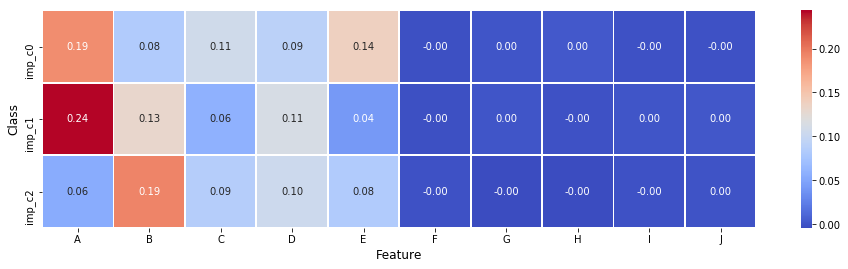

In [23]:
fig, ax = plt.subplots(figsize=(16, 4))
sns.heatmap(mat_to_plot,
            annot=True, fmt='.2f', linewidths=0.9,
            linecolor='white',  cmap='coolwarm')
ax.set_ylabel('Class', fontsize=12)
ax.set_xlabel('Feature', fontsize=12)

In [39]:
# fi_obj.fi_p.sort_values('imp_cls0', ascending=False)

In [38]:
# fi_obj.fi_p.sort_values('imp_cls1', ascending=False)

In [37]:
# fi_obj.fi_p.sort_values('imp_cls2', ascending=False)